In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
import os
import sys
import seaborn as sns
import pandas as pd
from pandapower import networks as pn
from pandapower import estimation as est
import pandapower as pp
from pandapower import OPFNotConverged
from scipy.stats import multivariate_normal
from copy import deepcopy
sys.path.append('..')


from src.data_utils import grid_data
from src.estimators.adaptive import AdaptiveEstimator
from src.estimators.static import SecurityAssessmentEstimator
from src.samplers.sampler import Sampler

In [2]:
net = pn.case9()
pp.runopp(net, numba=True)
net.res_gen
net.gen['p_mw'] = net.res_gen['p_mw']
net.gen['vm_pu'] = net.res_gen['vm_pu']
net.gen
# phase angle difference... in pandapower they say there is no bounds on that except refernce buses
# What to check:
## 1) line currents and flows at all lines
## 2) Vm at all buses
## 3) p_mw, q_mw at gens

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,slack_weight
0,1,True,True,None,134.482648,1.0,NaN,None,1.060623,False,300.0,10.0,300.0,-300.0,0.0
1,2,True,True,None,94.326645,1.0,NaN,None,1.042557,False,270.0,10.0,300.0,-300.0,0.0


In [7]:
fluct_gen = [0, 1]
fluct_load = [0, 1, 2]
adaestimator = AdaptiveEstimator(net, fluct_gen, fluct_load, np.ones(len(fluct_gen)) * 0, 500, batch_size=2)
staticestimator = SecurityAssessmentEstimator(net, fluct_gen, fluct_load)

In [4]:
get_sample = lambda: np.random.multivariate_normal(np.zeros(len(fluct_gen)), np.eye(len(fluct_gen)) * 500)
get_sample_load = lambda: {"P": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 500), 
                            "Q": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 500), }
sampler = Sampler(len(fluct_gen), len(fluct_load), get_sample, get_sample_load).sample()
samples = [(next(sampler), ) for i in range(10000)]
estimate_static = staticestimator.estimate(samples)

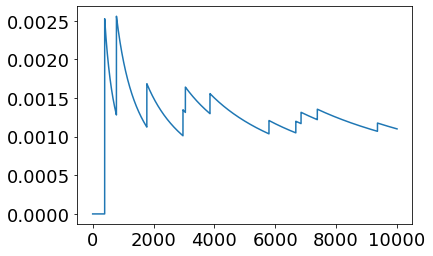

In [5]:
plt.plot([np.sum(estimate_static[:i]) / i for i in range(1, len(estimate_static))])

In [8]:
adaestimator.test_samples(5000)

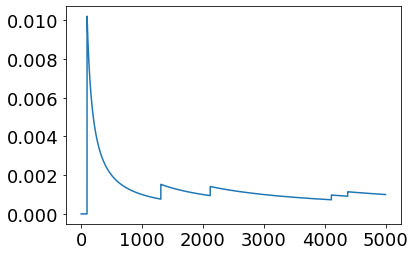

In [9]:
plt.plot([np.sum(adaestimator.weightes_outcomes[:i]) / i for i in range(1, adaestimator.n_steps)])


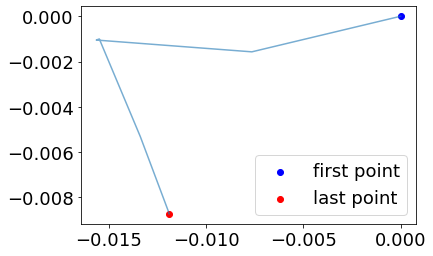

In [10]:
mus_hist = np.array(adaestimator.mu_history)
plt.plot(mus_hist[:, 0], mus_hist[:, 1], alpha=0.6)
plt.scatter([mus_hist[:, 0][0]], [mus_hist[:, 1][0]], color='blue', label='first point')
plt.scatter([mus_hist[:, 0][-1]], [mus_hist[:, 1][-1]], color='red', label='last point')
plt.legend()

In [ ]:
# покрасить в feasible / infeasible

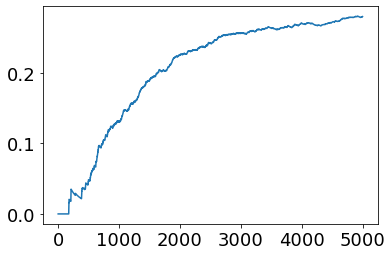

In [5]:
plt.plot([np.sum(adaestimator.weightes_outcomes[:i]) / i for i in range(1, adaestimator.n_steps)])

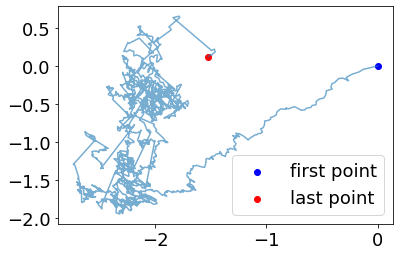

In [6]:
mus_hist = np.array(adaestimator.mu_history)
plt.plot(mus_hist[:, 0], mus_hist[:, 1], alpha=0.6)
plt.scatter([mus_hist[:, 0][0]], [mus_hist[:, 1][0]], color='blue', label='first point')
plt.scatter([mus_hist[:, 0][-1]], [mus_hist[:, 1][-1]], color='red', label='last point')
plt.legend()

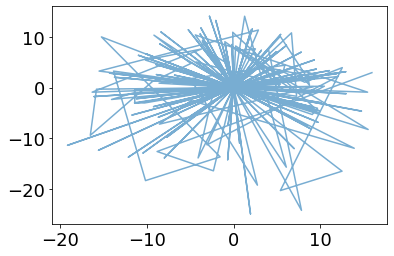

In [36]:
mus_hist = np.array(adaestimator.grad_history)
plt.plot(mus_hist[:, 0], mus_hist[:, 1], alpha=0.6)

# We can pose that as a searching machine for the WEAKEST area of the grid 
page rank lol - https://www.sciencedirect.com/science/article/abs/pii/S0378437118309993

In [ ]:
#